# Stage 2020-2021

# Active Learning appliqué aux films conducteurs transparents 

## 1- Importation des bibliothèques nécessaires

### a) Bibliothèques usuelles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### b) Bibliothèques du Machine Learning

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

### c) Bibliothèques de l'Active Learning

In [3]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import uncertainty_sampling
from modAL.disagreement import max_std_sampling

## 2- Importation des données 

In [4]:
data = pd.read_table("C:/Users/salma/OneDrive/Bureau/Stage 2020-2021/Machine Learning/Publications/Electrode_publication/Data/DOE(GSD)_1stRUN_avec32.data", sep=',')
data

,Set,Cu_content,Temperature (°C),Time (min),EDTA,FoM (μS),no.of samples
0,1,0.65,60,30,0.02,138.0,3
1,2,0.65,60,60,0.03,178.0,3
2,3,0.65,60,90,0.07,110.0,3
3,4,0.65,60,120,0.10,148.0,3
4,5,0.65,70,30,0.03,193.0,3
5,6,0.65,70,60,0.07,184.0,3
6,7,0.65,70,90,0.10,18.2,3
7,8,0.65,70,120,0.02,32.8,3
8,9,0.65,80,30,0.07,54.0,3
9,10,0.65,80,60,0.10,35.2,3


In [5]:
data.shape

(32, 7)

**a)** On sépare les facteurs et la variable cible.

In [6]:
X = data[["Cu_content",'Temperature (°C)','Time (min)','EDTA']]
Y = data['FoM (μS)']

on transforme le dataframe en une matrice (numpy)

In [7]:
X_raw=X.to_numpy()
Y_raw=Y.to_numpy()

**b)** On choisit les premières instances étiquetées  

In [8]:
racine = 0
n_initial = X_raw.shape[0] 
size = 5
random.seed(racine)
lab_indices =  random.sample(range(n_initial), size)
print(lab_indices)

[24, 26, 2, 16, 31]


In [9]:
# Les données étiquetées.
X_lab = X_raw[lab_indices]
Y_lab = Y_raw[lab_indices] 

In [10]:
# Les données non-étiquetées.
X_unlab = np.delete(X_raw, lab_indices, axis=0) 
Y_unlab = np.delete(Y_raw, lab_indices, axis=0)

In [11]:
Y_unlab

array([138. , 178. , 148. , 193. , 184. ,  18.2,  32.8,  54. ,  35.2,
        72. ,  62.9,  14.8, 101. , 120. ,  58.1, 103. ,  54.4,  33.9,
        80.4,  24.9,  11. ,  32. ,  30.2,  51.1,  12.2, 125. , 149. ])

# Active Learning :

In [12]:
def strat_max(pred, X_unlab, Y_unlab) :
    m = max(pred)
    query_index = np.argmax(pred)
    query_instance = X_unlab[query_index]
    label_index = Y_unlab[query_index]
    return query_index, query_instance, m

In [13]:
model = RandomForestRegressor(random_state=0)
model.fit(X_lab,Y_lab)
pred = model.predict(X_unlab)
query_index_init, query_instance_init, label_index_init = strat_max(pred, X_unlab, Y_unlab)

In [14]:
n_queries = 15
performance = []
y_pred_max = [label_index_init]
for index in range(n_queries):
    model = RandomForestRegressor(random_state=0)
    model.fit(X_lab,Y_lab)
    query_index, query_instance, label_i = strat_max(pred, X_unlab, Y_unlab)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    y_pred_max.append(label_i)
    X_lab, Y_lab= np.vstack([X_lab, query_instance]), np.hstack([Y_lab, label_i])    
    X_unlab, Y_unlab = np.delete(X_unlab, query_index, axis=0), np.delete(Y_unlab, query_index)
    # Remove the queried instance from the unlabeled pool.
    #print(predictions)
    pred = model.predict(X_unlab)
    print(pred)
    score = model.score(X,Y)
    performance.append(score)
    lab_indices.append(query_index)

5
[65.501 65.501 77.551 65.501 63.74  80.12  55.647 55.647 84.314 76.41
 52.888 61.215 82.413 65.176 41.957 58.9   51.055 41.957 37.952 58.9
 56.509 30.805 57.242 26.105 41.078 60.451]
8
[71.8426 71.8426 92.6318 68.9484 67.5792 83.1761 59.4557 63.8662 80.6171
 59.4391 62.1812 77.2111 68.0334 43.59   63.745  62.6597 42.3709 38.9867
 63.6508 58.1665 36.7345 58.3565 31.0154 38.4277 55.9508]
2
[74.549   74.549   70.63394 70.42182 85.61188 67.00326 67.76786 82.76458
 65.63672 66.04324 83.4733  78.71782 37.692   54.0757  49.8991  37.65184
 31.5675  52.4555  54.61864 31.8909  55.98042 28.6619  38.41014 58.84242]
4
[74.474294 74.474294 70.163018 71.229294 65.136396 65.338922 84.739942
 60.533484 60.67956  79.65592  77.779914 39.759    59.02699  55.17834
 38.70084  33.035118 56.24119  60.288624 31.161836 61.973514 25.286818
 35.72514  57.93156 ]
6
[71.1249124 71.1249124 64.6650324 62.886232  58.574738  58.749838
 54.107718  58.417434  76.9585704 71.5133116 44.0621188 62.4047448
 56.5210676 41.9

Text(0, 0.5, 'PCE prédit')

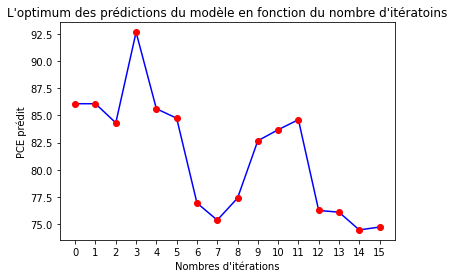

In [18]:
plt.title("L'optimum des prédictions du modèle en fonction du nombre d'itératoins")
plt.plot(np.arange(n_queries+1), y_pred_max, 'b')
plt.plot(np.arange(n_queries+1), y_pred_max, 'ro')
plt.xticks(np.linspace(0,n_queries,n_queries+1,endpoint=True))
plt.xlabel("Nombres d'itérations")
plt.ylabel("PCE prédit")

Text(0, 0.5, 'La performance du modèle')

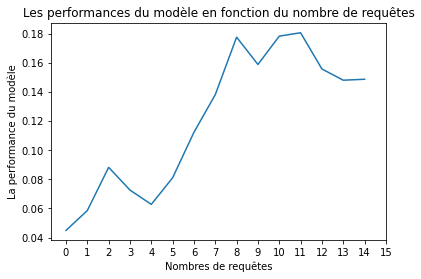

In [17]:
plt.title("Les performances du modèle en fonction du nombre de requêtes")
plt.plot(np.arange(n_queries), performance)
plt.xticks(np.linspace(0,n_queries,n_queries+1,endpoint=True))
plt.xlabel("Nombres de requêtes")
plt.ylabel("La performance du modèle")

In [ ]:
n_queries = 15
racine = 0
performance = []
for index in range(n_queries):
    model = RandomForestRegressor(random_state = racine)
    model.fit(X_lab,Y_lab)
    pred = model.predict(X_unlab)
    score = model.score(X_unlab,Y_unlab)
    performance.append(score)
    print(pred)
    query_index, query_instance, label_i = strat_max(pred, X_unlab, Y_unlab)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    X_new, Y_new = X_unlab[query_index].reshape(1, -1), Y_unlab[query_index].reshape(1, )
    #committee1.teach(X=X_new, y=Y_new)
    # Remove the queried instance from the unlabeled pool.
    #print(predictions)
    plt.figure(figsize=(25, 25))
    plt.subplot(5,4,index+1)
    for label, data in data.groupby('Set'): 
        p1, = plt.plot(Y_unlab, pred, 'ko')
        #plt.plot(Y_unlab[query_index], )
        #p2, = plt.plot(Y_lab,pred[lab_indices],'ro')
        p3, = plt.plot(Y[query_index], pred[query_index], 'go')
        plt.title('iteration no %d' % (index+1))
    #X_unlab, Y_unlab = np.delete(X_unlab, query_index, axis=0), np.delete(Y_unlab, query_index)
    X_lab, Y_lab= np.vstack([X_lab, query_instance]), np.hstack([Y_lab, label_i])    
    plt.plot([-1, 200], [-1, 200], ls = "--", c = ".3")  
    plt.autoscale(enable = False)                    
    plt.legend([p1,p3],["le jeu de données","données rajoutées"], loc ='upper left')
    plt.xlim(0,200)                             
    plt.ylim(0,200)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    font = {'size': 15}
    plt.xlabel(r'Measured pce', font)
    plt.ylabel(r'Predicted pce', font)